In [1]:
#####################################
# author : ensp-africa-translate team
#####################################
#####################################
# To execute this cell, no need to modify
#####################################
# Les imports
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
#  matplotlib : use here to plot attention 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# sklearn : use here to separate data into training and test data.
from sklearn.model_selection import train_test_split
# nltk : use here to separate sentences into words and texts into sentences.
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
# other important modules
import unicodedata
import re
import numpy as np
import os
import io
import time
import csv
from collections import Counter

###################################
# The constants
unknow = 'unknow' # helps translate unknown words.
autocompleteword = 'autocomplete' #  During the experiments, they allowed us to make sure that all of our data had a size multiple of 5.
                                  # But in the end we abandoned this idea
SOS = '<start> ' # use as chain start symbol (start of string)
EOS = ' <end>'   # use as end of chain symbol (end of  string)
####################################
####################################
# Useful methods for word processing. Below is an overview of what these methods do, in order.
"""
1. Add a start and end token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.
5. Remove the accents
6. Clean the sentences
7. Complete the dataset
8. Return word pairs in the format: [input_language, target_language]
"""

def unicode_to_ascii(s):
  """Converts the unicode file to ascii"""
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def autocomplete(sentence, complete = False):
  """complete the sentence"""
  if complete :
    wp = sentence.strip()
    if wp != "" :
      m = len(word_tokenize(wp))
      if m%5 == 0 :
        return sentence
      else :
        end = wp[-1] 
        if end in ["?", "!", "."] :
          wp = wp[:len(wp)-1]
        else :
          end = ""
        for i in range((int(m/5)+1)*5 - m) :
          wp=wp+' '+autocompleteword 
        return wp + end
    return sentence
  return sentence

def preprocess_sentence(word, otherAutorizedSymbols=''):
  """
  stip([chars]) returns a copy of the string in which all the characters passed in parameter
  have been removed from the beginning of the chain.
  """
  wordp = unicode_to_ascii(word.lower().strip())
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  
  #s = 'bla. bla? bla.bla! bla...'
  #import re
  #s = re.sub('([.,!?()])', r' \1 ', s)
  #s = re.sub('\s{2,}', ' ', s)
  #print(s) # bla . bla ? bla . bla ! bla . . .

  wordp = re.sub(r"([?.!,¿])", r" \1 ", wordp)
  wordp = re.sub(r'[" "]+', " ", wordp)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",") + otherAutorizedSymbols
  wordp = re.sub(r"[^a-zA-Z?.!,¿"+otherAutorizedSymbols+"]+", " ", wordp)
  # rstrip([chars]) returns a copy of the string with the ending characters removed (depending on the string 
  # argument passed). If no argument is passed, it removes spaces the end.
  wordp = wordp.rstrip().strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  wordp = SOS + wordp + EOS
  print(wordp)
  return wordp

def EPE(s):
  """use to know (statistically) the most appropriate punctuation mark to end a sentence."""
  s = s.strip()
  if len(s) > 1:
      frequence = Counter(s)
      frequence = [frequence["?"], frequence["!"], frequence["."]] 
      end = '.' if max(frequence) == 0 else ["?", "!","."][np.argmax(frequence)]
      """Traite les espacement inutiles et enleve les points"""
      s = s.replace('  ', ' ').replace('  ', ' ')
      s = s.replace(' . ', ' ').replace('. ', ' ').replace(' .', ' ').replace('.', ' ')
      s = s.replace(' ! ', ' ').replace('! ', ' ').replace(' !', ' ').replace('!', ' ')
      s = s.replace(' ? ', ' ').replace('? ', ' ').replace(' ?', ' ').replace('?', ' ')
      try :
        if s[-1] in [',',';']:
          s = s[:len(s)-1]
      except Exeption as e :
        pass
      s = s.replace('  ', ' ').replace('  ', ' ').strip() +''+ end
      print(s)
  return s

def help_preprocess_lines(word, otherAutorizedSymbols):
  word = unicode_to_ascii(word.lower().strip())
  word = re.sub(r"[^a-zA-Z?.!,¿"+otherAutorizedSymbols+"]+", " ", word)
  word = word.rstrip().strip()
  return word

def preprocess_lines(lines, otherAutorizedSymbols, sentencesSeparator=None):
  """We found that some data consisted of several sentences, this method is there to extract these sentences.
   It also makes it possible to remove the errors left by webscraping in our data
  """
  if sentencesSeparator :
    result = []
    for line in lines :
      e = line.split(sentencesSeparator)
      if e[0] != "__Error__" and e[1]!= "__Error__" :
        lignes_i = sent_tokenize(e[0])
        lignes_j = sent_tokenize(e[1])
        l = len(lignes_i)
        if l == len(lignes_j) :
          for k in range(l) :
            result.append(EPE(lignes_i[k])+sentencesSeparator+EPE(lignes_j[k])+'\n')
        else :
            lignes_i = EPE(e[0]) 
            lignes_j = EPE(e[1])
            result.append(lignes_i+sentencesSeparator+lignes_j+'\n')
    for line in result.copy() :
      e = line.split(sentencesSeparator)
      lignes_i = help_preprocess_lines(e[0], otherAutorizedSymbols).split(',')
      lignes_j = help_preprocess_lines(e[1], otherAutorizedSymbols).split(',')
      l = len(lignes_i)
      if l == len(lignes_j) :
        for k in range(l) :
          result.append(EPE(lignes_i[k])+sentencesSeparator+EPE(lignes_j[k])+'\n')
    return result
  else :
    return lines
    
def dataset(path):
  """"load dataset from path"""
  if path['src'] == 'txt':
    return io.open(path['path_to_file'], encoding='UTF-8').read().strip().split('\n')
  if path['src'] =='csv':
    lines = []
    with open(path['path_to_file'], 'r') as csvfile:
        f_csv = csv.reader(csvfile)
        fieldnames = next(f_csv)
        i = fieldnames.index(path["fieldnames"][0])
        j = fieldnames.index(path["fieldnames"][1])
        for ligne in f_csv:
          lines.append(ligne[i]+path['sentencesSeparator']+ligne[j])
    return lines  

def ne_help(num_ex, l):
  """limit the num_examples"""
  if num_ex :
    return l >= num_ex
  else :
    return False

def create_dataset(paths, num_examples, sentencesSeparator, otherAutorizedSymbols=''):
  """create dataset using specified paths : can be csv or txt"""
  lines = []
  for path in paths :
    lines = lines + dataset(path)
    if ne_help(num_examples, len(lines)) :
      break
  s = None if sentencesSeparator=='\t' else sentencesSeparator
  word_pairs = [
        [preprocess_sentence(autocomplete(w), otherAutorizedSymbols=otherAutorizedSymbols) for w in l.split(sentencesSeparator)]  
          for l in preprocess_lines(lines[:num_examples], otherAutorizedSymbols ,sentencesSeparator=s)
        ]
  return zip(*word_pairs)
      
def max_length(tensor):
  return max(len(t) for t in tensor)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer

def load_dataset(paths, sentencesSeparator, num_examples=None,otherAutorizedSymbols=''):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(paths, num_examples, sentencesSeparator, otherAutorizedSymbols)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

def convert(lang, tensor):
    for t in tensor:
      if t!=0:
        print ("%d ----> %s" % (t, lang.index_word[t]))
    print()

class Encoder(tf.keras.Model):
  """encoder model : see tensorflow keras Model  documentation to have more information about implementation"""
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

class BahdanauAttention(tf.keras.layers.Layer):
  """Attention layer : fine Minh-Thang Luong thesis to have more information about."""
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class Decoder(tf.keras.Model):
  """decoder model : see tensorflow keras Model  documentation to have more information about implementation"""
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

###########################################
###########################################
# main class of our work.
# Here we implement a class allowing to train a model to translate text automatically from any language to another, 
# provided that it is fed with the data of the target languages.
# If you are only interested in the results, you can go directly to the following cells to see it in action
###########################################
###########################################
class Trainer():
  def __init__(self, input_language, target_language, paths_to_dataset, sentencesSeparator,
               num_examples=None, test_size=0.2, otherAutorizedSymbols=''):  
    """
    These first two parameters are to be taken seriously. Although they are harmless, they allow us to create the 
    backup folder of the parameters of the model during training
    """
    self.input_language = input_language # name of the input languages
    self.target_language = target_language # name of the target language 
    self.paths_to_dataset = paths_to_dataset
    """
    We all have that in African languages ​​we meet symbols that are not in the French / English alphabet. 
    See the following cells for the extraction process of these rare symbols
    """
    self.otherAutorizedSymbols = otherAutorizedSymbols
    
    self.num_examples = num_examples 
    self.test_size=test_size
    # Try experimenting with the size of that dataset
    self.input_tensor, self.target_tensor, self.inp_lang, self.targ_lang = load_dataset(
        self.paths_to_dataset, sentencesSeparator, self.num_examples, self.otherAutorizedSymbols 
    )
    # Calculate max_length of the target tensors
    self.max_length_targ, self.max_length_inp = max_length(self.target_tensor), max_length(self.input_tensor)
    # Creating training and validation sets using an 80-20 split
    self.input_tensor_train, self.input_tensor_val, self.target_tensor_train, self.target_tensor_val = train_test_split(self.input_tensor, self.target_tensor, test_size=self.test_size)
    # Show length
    print(len(self.input_tensor_train), len(self.target_tensor_train), len(self.input_tensor_val), len(self.target_tensor_val))
    print()

  """
  * batch_size: Integer or None. Number of samples per gradient update. If unspecified, 
  batch_size will default to 32. Do not specify the batch_size if your data is in the form of symbolic 
  tensors, dataset, generators, or keras.utils.Sequence instances (since they generate batches).
  """  
  def createDataset(self, BATCH_SIZE = 64, embedding_dim = 256, units = 1024) :
    """Create a tf.data dataset"""
    self.BUFFER_SIZE = len(self.input_tensor_train)
    self.BATCH_SIZE = BATCH_SIZE
    self.steps_per_epoch = len(self.input_tensor_train)//self.BATCH_SIZE
    self.embedding_dim = embedding_dim
    self.units = units
    self.vocab_inp_size = len(self.inp_lang.word_index)+1
    self.vocab_tar_size = len(self.targ_lang.word_index)+1
    # todo : remplacer tf par self  
    self.dataset = tf.data.Dataset.from_tensor_slices((self.input_tensor_train, self.target_tensor_train)).shuffle(self.BUFFER_SIZE)
    self.dataset = self.dataset.batch(self.BATCH_SIZE, drop_remainder=True)
    self.example_input_batch, self.example_target_batch = next(iter(self.dataset))
    self.example_input_batch.shape, self.example_target_batch.shape
  
  def encode(self):
    self.encoder = Encoder(self.vocab_inp_size, self.embedding_dim, self.units, self.BATCH_SIZE)
    # sample input
    self.sample_hidden = self.encoder.initialize_hidden_state()
    self.sample_output, self.sample_hidden = self.encoder(self.example_input_batch, self.sample_hidden)
    
    print ('Encoder output shape: (batch size, sequence length, units) {}'.format(self.sample_output.shape))
    print ('Encoder Hidden state shape: (batch size, units) {}'.format(self.sample_hidden.shape))

  def addAttention(self, unitsOfAttention=10):
    self.attention_layer = BahdanauAttention(units=unitsOfAttention)
    self.attention_result, self.attention_weights = self.attention_layer(self.sample_hidden, self.sample_output)
    print("Attention result shape: (batch size, units) {}".format(self.attention_result.shape))
    print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(self.attention_weights.shape))

  def decode(self):
    self.decoder = Decoder(self.vocab_tar_size, self.embedding_dim, self.units, self.BATCH_SIZE)
    self.sample_decoder_output, _, _ = self.decoder(tf.random.uniform((self.BATCH_SIZE, 1)), self.sample_hidden, self.sample_output)
    print ('Decoder output shape: (batch_size, vocab size) {}'.format(self.sample_decoder_output.shape))

  # Define the optimizer and the loss function
  def optimize(self, checkpoint_dir):
    self.optimizer = tf.keras.optimizers.Adam()
    self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    self.checkpoint_dir = checkpoint_dir
    self.checkpoint_prefix = os.path.join(checkpoint_dir+'/'+self.input_language+'_'+self.target_language, "ckpt")
    self.checkpoint = tf.train.Checkpoint(optimizer=self.optimizer, encoder=self.encoder, decoder=self.decoder)

  def loss_function(self, real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = self.loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)
  
  ######## Training
  @tf.function
  def train_step(self, inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
      enc_output, enc_hidden = self.encoder(inp, enc_hidden)

      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([self.targ_lang.word_index['<start>']] * self.BATCH_SIZE, 1)

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)

        loss += self.loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = self.encoder.trainable_variables + self.decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    self.optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

  def train(self, EPOCHS=10):
    for epoch in range(EPOCHS):
      start = time.time()

      enc_hidden = self.encoder.initialize_hidden_state()
      total_loss = 0

      for (batch, (inp, targ)) in enumerate(self.dataset.take(self.steps_per_epoch)):
        batch_loss = self.train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
          print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                      batch,
                                                      batch_loss.numpy()))
      # saving (checkpoint) the model every 2 epochs
      if (epoch + 1) % 2 == 0:
        self.checkpoint.save(file_prefix = self.checkpoint_prefix)

      print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / self.steps_per_epoch))
      print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  # Translate
  def evaluate(self, sentence):
    attention_plot = np.zeros((self.max_length_targ, self.max_length_inp))

    sentence = preprocess_sentence(autocomplete(sentence), self.otherAutorizedSymbols)
    inputs = []
    try :
      inputs = [self.inp_lang.word_index[i] for i in sentence.split(' ')]
      inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                            maxlen=self.max_length_inp,
                                                            padding='post')
      inputs = tf.convert_to_tensor(inputs)

      result = ''

      hidden = [tf.zeros((1, self.units))]
      enc_out, enc_hidden = self.encoder(inputs, hidden)

      dec_hidden = enc_hidden
      dec_input = tf.expand_dims([self.targ_lang.word_index['<start>']], 0)

      for t in range(self.max_length_targ):
        predictions, dec_hidden, attention_weights = self.decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += self.targ_lang.index_word[predicted_id] + ' '

        if self.targ_lang.index_word[predicted_id] == '<end>':
          return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

      return result, sentence, attention_plot
    except Exception as ex :
      raise ex

  # function for plotting the attention weights
  def plot_attention(self, attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
  
  def afterTranslate(self, sentence): 
    s =  word_tokenize(sentence) #.split(' ') 
    print(s)
    l = len(s)
    if l > 1 :
      sc = s.copy()
      for k in range(1, int(l/2) + 1):
        for i in range(l - 2*k + 1):
          if s[i:i+k-1+1] == s[i+k:i+2*k-1+1]:
            for j in range(i, i+k-1+1+1) :
              try :
                del sc[j]
              except :
                pass
      a = sc[0]
      del sc[0]
      for s in sc :
        a = a + ' ' + s
      return a
    else :
      return sentence

  ## Make translation
  def help_translate(self, sentence):
    s = sentence
    try :
      result, sentence, attention_plot = self.evaluate(sentence)
      print('Input: %s' % (sentence))
      print('Predicted translation: {}'.format(result))
      attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
      self.plot_attention(attention_plot, sentence.split(' '), result.split(' '))
      return self.afterTranslate(sentence)
    except Exception as ex :
      print(ex)
      return self.afterTranslate(s)

  def translate(self, text):
    """
    try :
      sentences = sent_tokenize(str(text))
      print('sentences', sentences)
      result = self.help_translate(sentences[0]) 
      del sentences[0]
      for sentence in sentences :
        result = result + self.help_translate(sentence)
      return result
    except :
      return text 
    """
    return self.help_translate(text)
      
  def restoreCheckpoint(self):
    self.checkpoint.restore(tf.train.latest_checkpoint(self.checkpoint_dir+'/'+self.input_language+'_'+self.target_language))
  
  def compileAll(self, checkpoint_dir = './training_checkpoints'):
    self.createDataset()
    self.encode()
    self.addAttention()
    self.decode()
    self.optimize(checkpoint_dir=checkpoint_dir)
    

TensorFlow 2.x selected.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**langues**

Here a simple translator from French to Bafia (languages ​​spoken in the Center Cameroon region) and vice versa.

To test the other models, please make sure you have the appropriate dataset and specify the appropriate paths.

To see all the models already training and datasets for future training, see the project description

Since we are working with symbols that are not present in the French / English languages, we use the vocabularies extracted during the preparation of the dataset to find the rare symbols.

In [2]:
###
# Modify the path of the folder containing the vocabulary if necessary
# See the list of all languages ​​below (main_list)
###
langue = "Bafia" 
vocabulairy_path = "/content/drive/My Drive/datasets/YourVersion/vocabulaires/"+langue+".txt"
otherAutorizedSymbols=""
with open(vocabulairy_path, "r") as vocab:
  for symbol in vocab.readlines() : 
    try :
      otherAutorizedSymbols=otherAutorizedSymbols+symbol.split(' __:__ ')[0]
    except Exception as e:
      print(e)
ignored_tokens = ['.', '!','?',',',';',':','...','(',')','«','»','-','<','>', '[',']']
s = Counter(otherAutorizedSymbols+"âéèêîôûù").keys()
otherAutorizedSymbols = ""
for e in s :
  if not e in ignored_tokens :
    otherAutorizedSymbols = otherAutorizedSymbols + e
print(otherAutorizedSymbols.rstrip('-'))

Abirahm̀ylIsgYkɔɓɛZudenFTƐNSRBotOɗfDvŋUwzEMcjKpŊƁGWPLJ́CƊ'Hâéèêîôûù


In [0]:
fr_or_en = 'Francais' # or 'Anglais' (voir plus bat)

Translation from Bafia to French

**If you have an error regarding shape incompatibility, re-train the model, we have expressly deleted some checkpoint because of memory problems.**

In [4]:
### Also change the storage path of the dataset depending on where you store it. 
# See the project description for more details
paths_to_file = [ 
  {
    "path_to_file":"/content/drive/My Drive/datasets/YourVersion/txts/"+fr_or_en+"_"+langue+"_pnb1.txt",
    "src":"txt",
    "sentencesSeparator":"__SEPARATOR__"
  }
]
   
tbf = Trainer(langue, fr_or_en, 
              paths_to_dataset=paths_to_file, 
              sentencesSeparator="__SEPARATOR__", 
              num_examples=None, 
              test_size=0.1,
              otherAutorizedSymbols=otherAutorizedSymbols)
print("Input Language; index to word mapping", convert(tbf.inp_lang, tbf.input_tensor_train[0]),)
print("Target Language; index to word mapping", convert(tbf.targ_lang, tbf.target_tensor_train[0]))
### Put the way or to be stored the checkpoints (also see the project description)
tbf.compileAll("/content/drive/My Drive/datasets/YourVersion/checkpoint_dir")
### If first training, comment this line
tbf.restoreCheckpoint()
### If first training, uncomment this line and change the number of epoch if necessary
tbf.train(EPOCHS=10) # environ 30 minutes avec le GPU

Streaming output truncated to the last 5000 lines.
<start> nsoo ɓitoki ɓyaa teghɛɛ ɓi ziinɛ yɛɛ cɛ . <end>
<start> il n'en est aucune qui consiste en sons inintelligibles . <end>
<start> kidɛŋ ki yin wɔɔ ki ɓɛ kpaa lɛ ki resii ɓi com . <end>
<start> car si je prie en langue . <end>
<start> ɓisuulɛ caamɛn ki mɓɔɔɓɔŋzag ɓi kikenekene ki kitoki . <end>
<start> mon esprit est en priere . <end>
<start> lɔŋ nghay wɛm wɛɛ ɓɔɔɓɔŋzag . <end>
<start> mais mon intelligence demeure sans fruit . <end>
<start> ɗyomzɛn ɗyɛm ɗyɔɔ maamaa ɗyɛ kɛɛ ki com . <end>
<start> que faire donc ? <end>
<start> nghɛɛsɛɛ min ki kii la ? <end>
<start> mais si tous prophetisent . <end>
<start> wɔlɛ i ɓum ɓɛcem ɓɛɛ kpaakpaŋzi ɓiɓan ɓi bɛll . <end>
<start> et qu'il survienne un infidele ou un homme non initie . <end>
<start> nni nnɛ ŋwaanɛ a yin ngherɛn nsoo lɛ ŋwaanɛ a yuu lɛ a wog a ɗiŋii yi . <end>
<start> il est convaincu par tous . <end>
<start> ɓum ɓɛcem ɓɛ ri nyi ɓii tinii lɛ a gherɛn kiɓe kii . <end>
<start> il 

<start> mɛ yɛɛ ri alfa ri omega . <end>
Input: <start> mɛ yɛɛ ri alfa ri omega . <end>
Predicted translation: je suis l'alpha et l'omega . <end> 


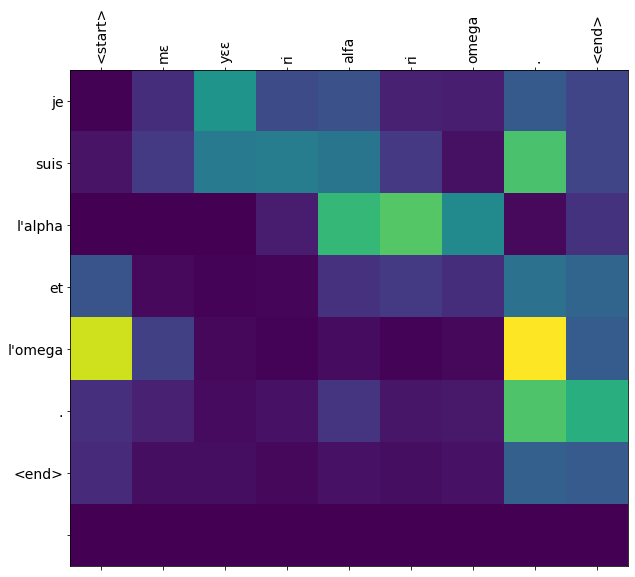

['<', 'start', '>', 'mɛ', 'yɛɛ', 'ri', 'alfa', 'ri', 'omega', '.', '<', 'end', '>']
<start> ŋwaa ntonto ri ŋwaa siiton . <end>
Input: <start> ŋwaa ntonto ri ŋwaa siiton . <end>
Predicted translation: le premier et le dernier . <end> 


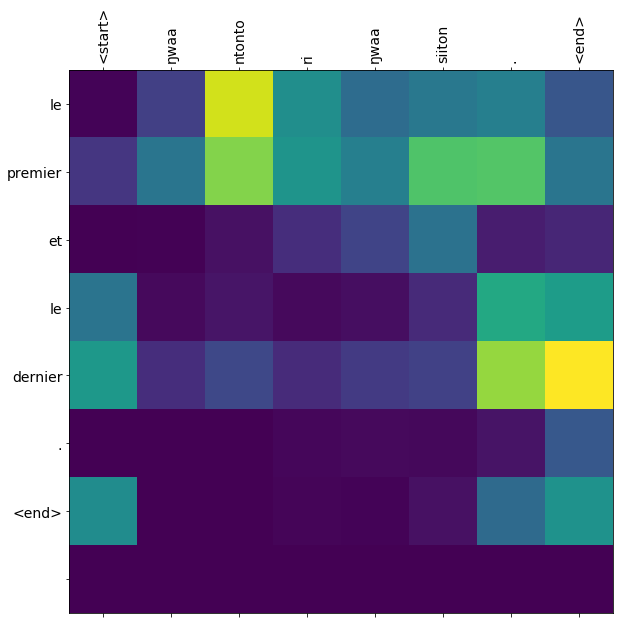

['<', 'start', '>', 'ŋwaa', 'ntonto', 'ri', 'ŋwaa', 'siiton', '.', '<', 'end', '>']
<start> ritumɛn ɗi risugtɛn . <end>
Input: <start> ritumɛn ɗi risugtɛn . <end>
Predicted translation: le commencement et la fin . <end> 


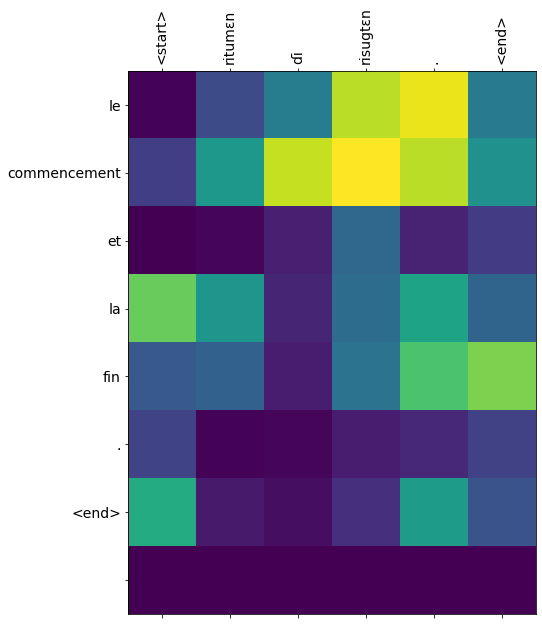

['<', 'start', '>', 'ritumɛn', 'ɗi', 'risugtɛn', '.', '<', 'end', '>']
<start> nɗi maa dooridoori anɛ ɓi boo i mum i davit . <end>
Input: <start> nɗi maa dooridoori anɛ ɓi boo i mum i davit . <end>
Predicted translation: c'est moi qui suis le rejeton et le fils de david . <end> 


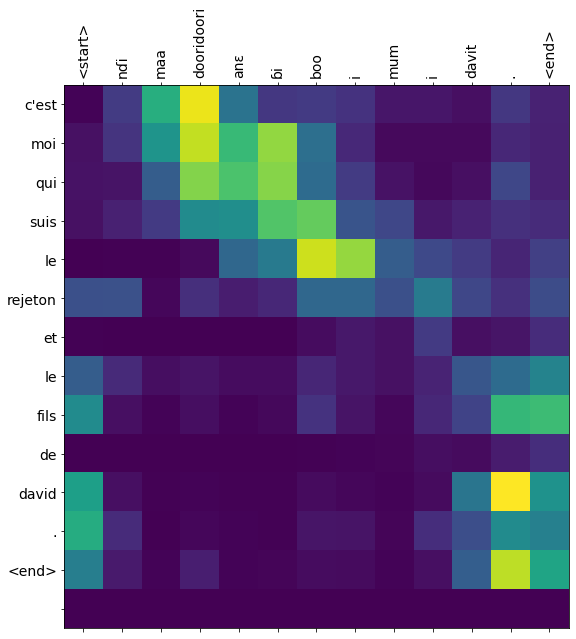

['<', 'start', '>', 'nɗi', 'maa', 'dooridoori', 'anɛ', 'ɓi', 'boo', 'i', 'mum', 'i', 'davit', '.', '<', 'end', '>']
<start> nki ɓati fyɛy fi fyɛɛ lonlom sariwa . <end>
Input: <start> nki ɓati fyɛy fi fyɛɛ lonlom sariwa . <end>
Predicted translation: l'etoile brillante du matin . <end> 


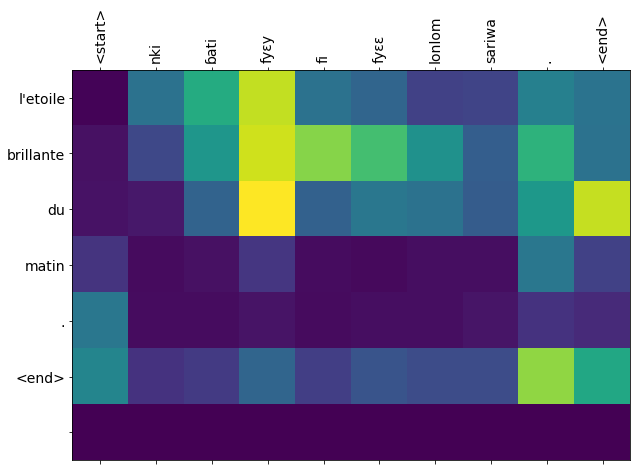

['<', 'start', '>', 'nki', 'ɓati', 'fyɛy', 'fi', 'fyɛɛ', 'lonlom', 'sariwa', '.', '<', 'end', '>']
<start> nni nghɛnga ŋwaa fitom adɛŋ di a rɛrɛlii ɓi ŋwos a lamɓɛnga tiili ticem ti ti lɛŋlɛŋga jɛɛ aɗyoo lɛ yuunay . <end>
Input: <start> nni nghɛnga ŋwaa fitom adɛŋ di a rɛrɛlii ɓi ŋwos a lamɓɛnga tiili ticem ti ti lɛŋlɛŋga jɛɛ aɗyoo lɛ yuunay . <end>
Predicted translation: et je vis un ange debout dans le soleil et il cria d'une voix forte a son nom . <end> 


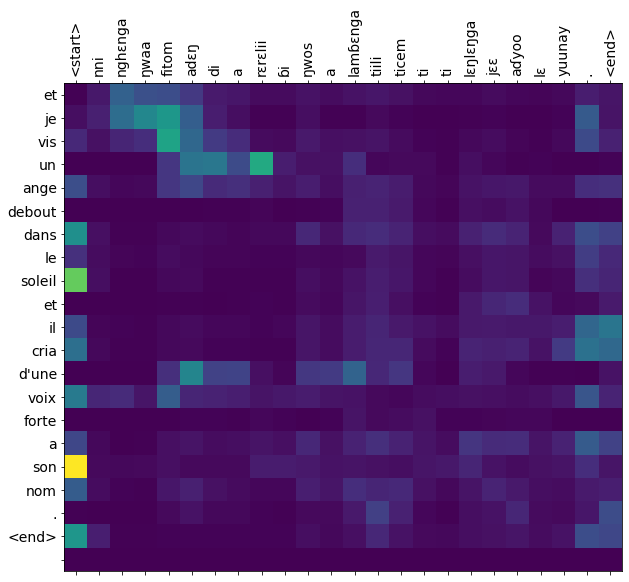

['<', 'start', '>', 'nni', 'nghɛnga', 'ŋwaa', 'fitom', 'adɛŋ', 'di', 'a', 'rɛrɛlii', 'ɓi', 'ŋwos', 'a', 'lamɓɛnga', 'tiili', 'ticem', 'ti', 'ti', 'lɛŋlɛŋga', 'jɛɛ', 'aɗyoo', 'lɛ', 'yuunay', '.', '<', 'end', '>']


'< start > nni nghɛnga ŋwaa fitom adɛŋ di a rɛrɛlii ɓi ŋwos a lamɓɛnga tiili ticem ti jɛɛ aɗyoo lɛ yuunay . < end >'

In [5]:
tbf.restoreCheckpoint()
tbf.translate(u"mɛ yɛɛ ri alfa ri omega .")
# target : je suis l'alpha et l'omega .
tbf.translate(u"ŋwaa ntonto ri ŋwaa siiton .")
#  target : le premier et le dernier .
tbf.translate(u"ritumɛn ɗi risugtɛn .")
#  target : le commencement et la fin .
tbf.translate(u"nɗi maa dooridoori anɛ ɓi boo i mum i davit .")
# target : c'est moi qui suis le rejeton et le fils de david .
tbf.translate(u"nki ɓati fyɛy fi fyɛɛ lonlom sariwa .")
# target : l'etoile brillante du matin .
tbf.translate(u"nni nghɛnga ŋwaa fitom adɛŋ di a rɛrɛlii ɓi ŋwos a lamɓɛnga tiili ticem ti ti lɛŋlɛŋga jɛɛ aɗyoo lɛ yuunay .")
# target : et je vis un ange debout dans le soleil et il cria d'une voix forte a tous les oiseaux qui volaient par le milieu du ciel venez ..

**Translation from French to Bafia**

In [6]:
paths_to_file = [ 
  {
    "path_to_file":"/content/drive/My Drive/datasets/YourVersion/txts/"+langue+"_"+fr_or_en+"_pnb1.txt",
    "src":"txt",
    "sentencesSeparator":"__SEPARATOR__"
  }
]
   
tbfI = Trainer(fr_or_en, langue, 
            paths_to_dataset=paths_to_file, sentencesSeparator="__SEPARATOR__", num_examples=None, test_size=0.1,
            otherAutorizedSymbols=otherAutorizedSymbols)
print("Input Language; index to word mapping", convert(tbfI.inp_lang, tbfI.input_tensor_train[0]),)
print("Target Language; index to word mapping", convert(tbfI.targ_lang, tbfI.target_tensor_train[0]))
tbfI.compileAll("/content/drive/My Drive/datasets/YourVersion/checkpoint_dir")
tbfI.restoreCheckpoint()
#tbfI.train(EPOCHS=20)

Streaming output truncated to the last 5000 lines.
<start> elle ne cherche point son interet . <end>
<start> kɛɛ wog bim . <end>
<start> elle ne s'irrite point . <end>
<start> kɛɛ ɓa ri mɛnyaaka . <end>
<start> elle ne tient pas compte du mal . <end>
<start> nkɔnɛn a ti kɛɛ wog kirɔɔ jaŋ inɛ mɛɓee mɛ ri . <end>
<start> elle ne prend pas plaisir a l'injustice . <end>
<start> a ti a nyaarag lɔŋ ri ɓiɓan ɓi ɓi ri lɛ saaɗ . <end>
<start> mais elle se rejouit de la verite . <end>
<start> nkɔnɛn a cenag ɓiɓan ɓicem . <end>
<start> elle excuse tout . <end>
<start> a gherag ɓiɓan ɓicem . <end>
<start> elle croit tout . <end>
<start> a ɗyaɓag ɓiɓan ɓicem . <end>
<start> elle espere tout . <end>
<start> a ki niɗki nɗem ri ɓiɓan ɓicem . <end>
<start> elle supporte tout . <end>
<start> ɓisuulɛ gaɓ i ɓiɓan yɛɛnɛ ti yii . <end>
<start> car nous ne connaissons qu'en partie . <end>
<start> ti ki kpaakpaŋzi ɓiɓan ɓi bɛll gaɓ idɛŋ yɔriyɔ . <end>
<start> et nous ne prophetisons qu'en partie . <end>
<star

<start> je suis l'alpha et l'omega . donner les moi vos mains , je vous benis ! <end>
Input: <start> je suis l'alpha et l'omega . donner les moi vos mains , je vous benis ! <end>
Predicted translation: nɗi alfa ri alfa ri omega , nɗi wɔ ɓii ɓɔni . <end> 


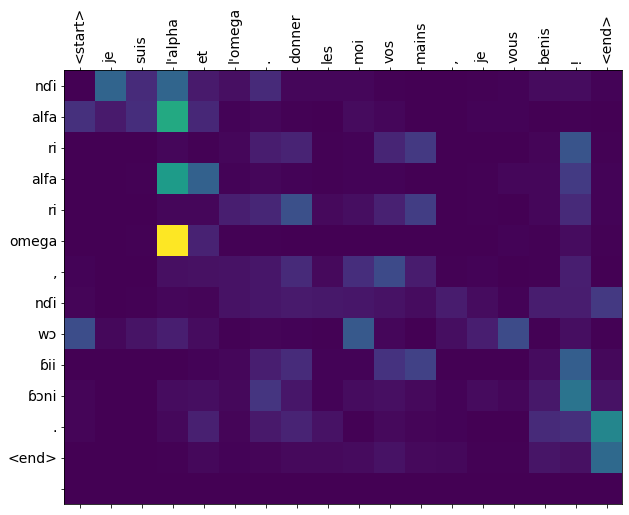

['<', 'start', '>', 'je', 'suis', "l'alpha", 'et', "l'omega", '.', 'donner', 'les', 'moi', 'vos', 'mains', ',', 'je', 'vous', 'benis', '!', '<', 'end', '>']
<start> le premier et le dernier . <end>
Input: <start> le premier et le dernier . <end>
Predicted translation: ŋwaa ntonto a ri roanɛ a ri ŋwaa siiton . <end> 


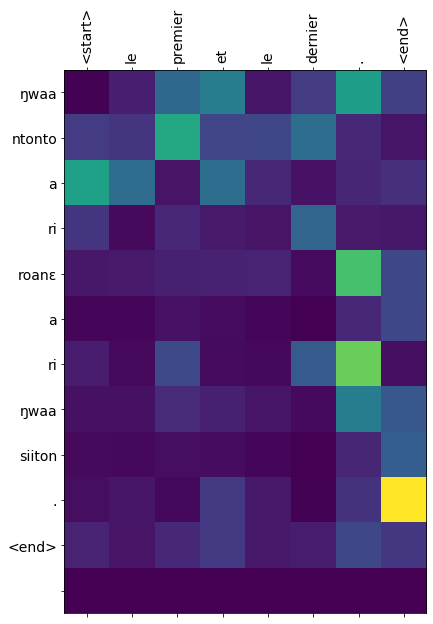

['<', 'start', '>', 'le', 'premier', 'et', 'le', 'dernier', '.', '<', 'end', '>']
<start> le commencement et la fin <end>
Input: <start> le commencement et la fin <end>
Predicted translation: ritumɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn ɗi risugtɛn 


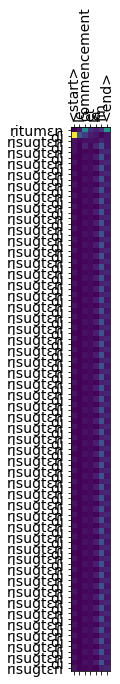

['<', 'start', '>', 'le', 'commencement', 'et', 'la', 'fin', '<', 'end', '>']
<start> il a venge le sang de ses serviteurs repandu par ses mains . <end>
Input: <start> il a venge le sang de ses serviteurs repandu par ses mains . <end>
Predicted translation: a ki rɔŋ bwaɓ yi ɓɛkii ɓisay ɓii ɓɛ a wowola . <end> 


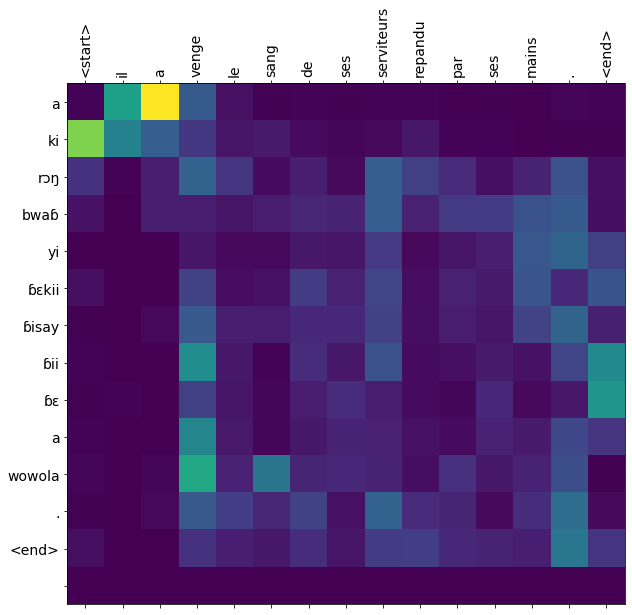

['<', 'start', '>', 'il', 'a', 'venge', 'le', 'sang', 'de', 'ses', 'serviteurs', 'repandu', 'par', 'ses', 'mains', '.', '<', 'end', '>']
<start> et ils dirent une seconde fois alleluia . <end>
Input: <start> et ils dirent une seconde fois alleluia . <end>
Predicted translation: nni ɓɛ ɓiitigha ti kikpaa lɛ aleluya . <end> 


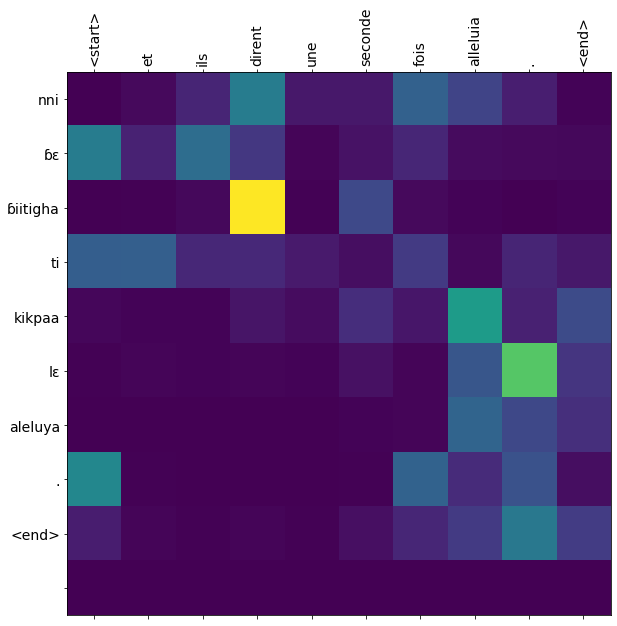

['<', 'start', '>', 'et', 'ils', 'dirent', 'une', 'seconde', 'fois', 'alleluia', '.', '<', 'end', '>']


'< start > et ils dirent une seconde fois alleluia . < end >'

In [7]:
tbfI.restoreCheckpoint()
tbfI.translate("je suis l'alpha et l'omega. donner les moi vos mains, je vous benis !")
tbfI.translate('le premier et le dernier.')
tbfI.translate('le commencement et la fin')
tbfI.translate('il a venge le sang de ses serviteurs repandu par ses mains.')
tbfI.translate("et ils dirent une seconde fois alleluia.")


**Translation from Bafia to English**


In [0]:
fr_or_en = 'Anglais' 

In [10]:
### Also change the storage path of the dataset depending on where you store it. 
# See the project description for more details
paths_to_file = [ 
  {
    "path_to_file":"/content/drive/My Drive/datasets/YourVersion/txts/"+fr_or_en+"_"+langue+"_pnb1.txt",
    "src":"txt",
    "sentencesSeparator":"__SEPARATOR__"
  }
]
   
tbf2 = Trainer(langue, fr_or_en, 
              paths_to_dataset=paths_to_file, 
              sentencesSeparator="__SEPARATOR__", 
              num_examples=None, 
              test_size=0.1,
              otherAutorizedSymbols=otherAutorizedSymbols)
print("Input Language; index to word mapping", convert(tbf.inp_lang, tbf.input_tensor_train[0]),)
print("Target Language; index to word mapping", convert(tbf.targ_lang, tbf.target_tensor_train[0]))
### Put the way or to be stored the checkpoints (also see the project description)
tbf2.compileAll("/content/drive/My Drive/datasets/YourVersion/checkpoint_dir")
### If first training, comment this line
tbf2.restoreCheckpoint()
### If first training, uncomment this line and change the number of epoch if necessary
#tbf2.train(EPOCHS=20) # environ 30 minutes avec le GPU

Streaming output truncated to the last 5000 lines.
<start> i ki cee ɓi lɛ yeesus kiris . <end>
<start> and him crucified . <end>
<start> ki ki ɓa lɛ yeesus kiris anɛ ɓɛ kpanga ɓi kɔrɔs . <end>
<start> and i was with you in weakness . <end>
<start> fɔɔnnɛ mɓagha foo a lɔŋkin lɛ ri ikɔg . <end>
<start> and in fear . <end>
<start> ri iris . <end>
<start> and in much trembling . <end>
<start> nki niniŋi lɛ kpag kpag kpag . <end>
<start> that your faith should not stand in the wisdom of men . <end>
<start> lɛ di righerɛn ɗin ɗyɛ kɛɛ saagh nto ɓi ɗyomzɛn ɗi ɓum . <end>
<start> but in the power of god . <end>
<start> ɗyɛɛ saagh lɔŋ nto ɓi teɗ wu bɛll . <end>
<start> howbeit we speak wisdom among them that are perfect yet not the wisdom of this world . <end>
<start> kɔlɛ ɗyomzɛn ɗidɛŋ ɗyɛɛɗi ɓisii reresi ɓɛkiristɛn ɓɛ ɓɛ mɛ kadɛn ɗyomzɛn ɗin ɗi yin ɗyomzɛn ɗi ɓi ziinɛ . <end>
<start> nor of the princes of this world . <end>
<start> nsoo lɛ ɗi mɛfom mɛ ɓi ziinɛ . <end>
<start> that come to noug

<start> mɛ yɛɛ ri alfa ri omega . <end>
Input: <start> mɛ yɛɛ ri alfa ri omega . <end>
Predicted translation: i am alpha and omega . <end> 


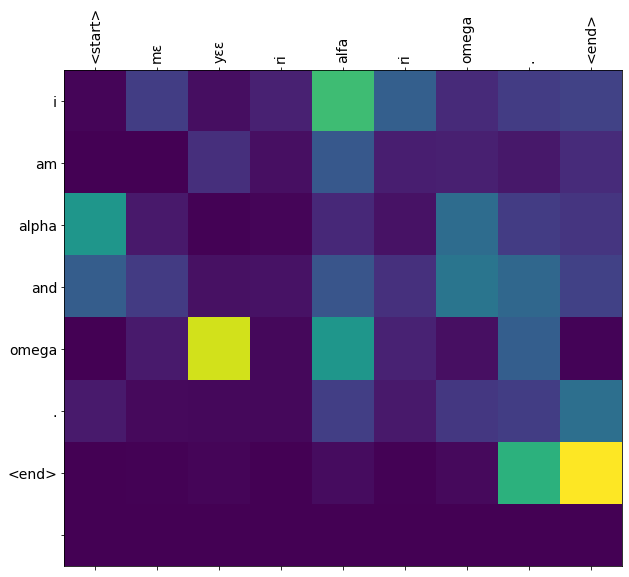

['<', 'start', '>', 'mɛ', 'yɛɛ', 'ri', 'alfa', 'ri', 'omega', '.', '<', 'end', '>']
<start> ŋwaa ntonto ri ŋwaa siiton . <end>
Input: <start> ŋwaa ntonto ri ŋwaa siiton . <end>
Predicted translation: the last . <end> 


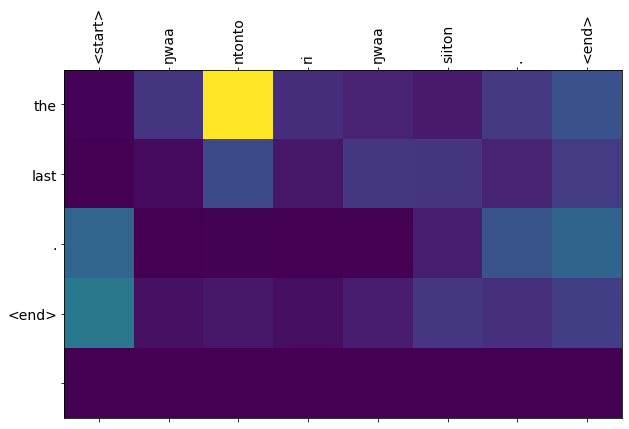

['<', 'start', '>', 'ŋwaa', 'ntonto', 'ri', 'ŋwaa', 'siiton', '.', '<', 'end', '>']
<start> ritumɛn ɗi risugtɛn . <end>
Input: <start> ritumɛn ɗi risugtɛn . <end>
Predicted translation: the last . <end> 


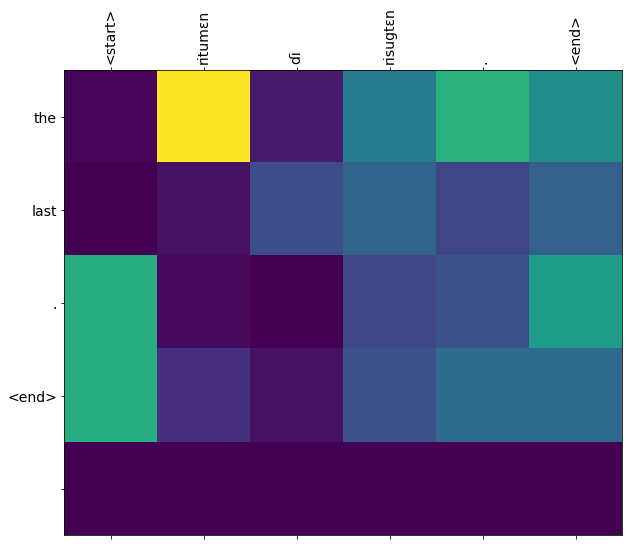

['<', 'start', '>', 'ritumɛn', 'ɗi', 'risugtɛn', '.', '<', 'end', '>']
<start> nɗi maa dooridoori anɛ ɓi boo i mum i davit . <end>
Input: <start> nɗi maa dooridoori anɛ ɓi boo i mum i davit . <end>
Predicted translation: i am the root and the offspring of david . <end> 


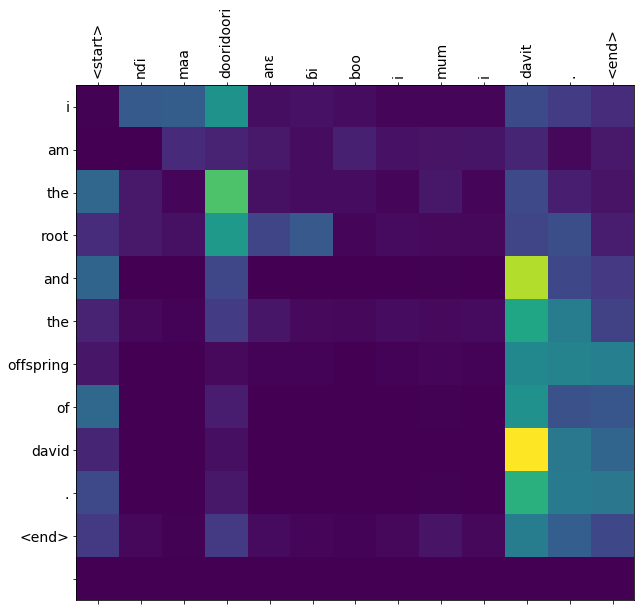

['<', 'start', '>', 'nɗi', 'maa', 'dooridoori', 'anɛ', 'ɓi', 'boo', 'i', 'mum', 'i', 'davit', '.', '<', 'end', '>']
<start> nki ɓati fyɛy fi fyɛɛ lonlom sariwa . <end>
Input: <start> nki ɓati fyɛy fi fyɛɛ lonlom sariwa . <end>
Predicted translation: and the bright and morning star . <end> 


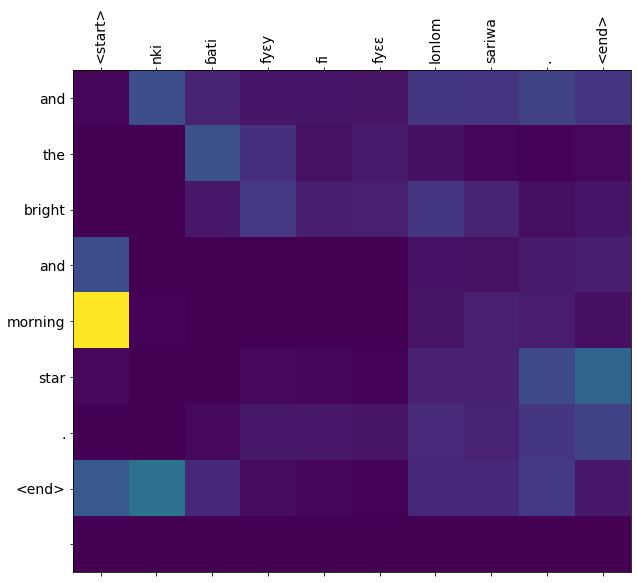

['<', 'start', '>', 'nki', 'ɓati', 'fyɛy', 'fi', 'fyɛɛ', 'lonlom', 'sariwa', '.', '<', 'end', '>']
<start> nni nghɛnga ŋwaa fitom adɛŋ di a rɛrɛlii ɓi ŋwos a lamɓɛnga tiili ticem ti ti lɛŋlɛŋga jɛɛ aɗyoo lɛ yuunay . <end>
Input: <start> nni nghɛnga ŋwaa fitom adɛŋ di a rɛrɛlii ɓi ŋwos a lamɓɛnga tiili ticem ti ti lɛŋlɛŋga jɛɛ aɗyoo lɛ yuunay . <end>
Predicted translation: and i saw an angel standing in the sun and he cried with a loud voice . <end> 


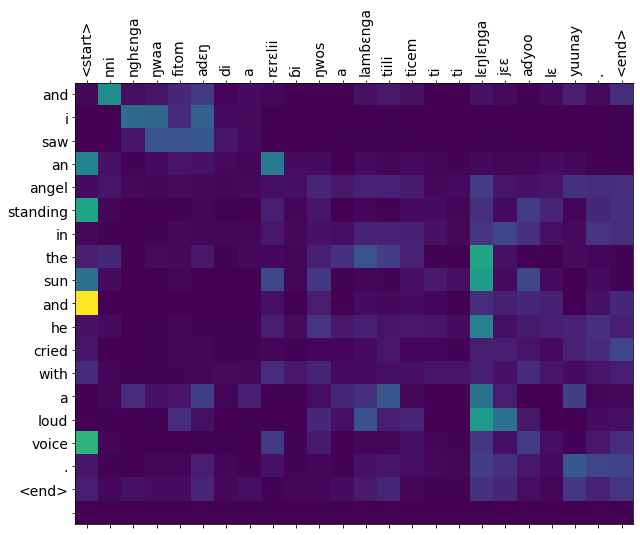

['<', 'start', '>', 'nni', 'nghɛnga', 'ŋwaa', 'fitom', 'adɛŋ', 'di', 'a', 'rɛrɛlii', 'ɓi', 'ŋwos', 'a', 'lamɓɛnga', 'tiili', 'ticem', 'ti', 'ti', 'lɛŋlɛŋga', 'jɛɛ', 'aɗyoo', 'lɛ', 'yuunay', '.', '<', 'end', '>']


'< start > nni nghɛnga ŋwaa fitom adɛŋ di a rɛrɛlii ɓi ŋwos a lamɓɛnga tiili ticem ti jɛɛ aɗyoo lɛ yuunay . < end >'

In [11]:
tbf2.restoreCheckpoint()
tbf2.translate(u"mɛ yɛɛ ri alfa ri omega .")
# target : i am alpha and omega .
tbf2.translate(u"ŋwaa ntonto ri ŋwaa siiton .")
#  target : the first and the last .
tbf2.translate(u"ritumɛn ɗi risugtɛn .")
#  target : the beginning and the end.
tbf2.translate(u"nɗi maa dooridoori anɛ ɓi boo i mum i davit .")
# target : it is I who am the offspring and the son of david.
tbf2.translate(u"nki ɓati fyɛy fi fyɛɛ lonlom sariwa .")
# target : the bright morning star.
tbf2.translate(u"nni nghɛnga ŋwaa fitom adɛŋ di a rɛrɛlii ɓi ŋwos a lamɓɛnga tiili ticem ti ti lɛŋlɛŋga jɛɛ aɗyoo lɛ yuunay .")
# and I saw an angel standing in the sun and he shouted in a loud voice to all the birds that flew through the middle of the sky come ..

**Translation from English to Bafia**

In [13]:
paths_to_file = [ 
  {
    "path_to_file":"/content/drive/My Drive/datasets/YourVersion/txts/"+langue+"_"+fr_or_en+"_pnb1.txt",
    "src":"txt",
    "sentencesSeparator":"__SEPARATOR__"
  }
]
   
tbfI2 = Trainer(fr_or_en, langue, 
            paths_to_dataset=paths_to_file, sentencesSeparator="__SEPARATOR__", num_examples=None, test_size=0.1,
            otherAutorizedSymbols=otherAutorizedSymbols)
print("Input Language; index to word mapping", convert(tbfI.inp_lang, tbfI.input_tensor_train[0]),)
print("Target Language; index to word mapping", convert(tbfI.targ_lang, tbfI.target_tensor_train[0]))
tbfI2.compileAll("/content/drive/My Drive/datasets/YourVersion/checkpoint_dir")
#tbfI2.restoreCheckpoint()
#tbfI2.train(EPOCHS=20)

Streaming output truncated to the last 5000 lines.
<start> that no flesh should glory in his presence . <end>
<start> lɛ nɗenga ɓi nɗem wɛm lɛ maa yi ɓi kiɓan kidɛŋ caamɛn kicem ki nɗi a lɔŋkin . <end>
<start> for i determined not to know any thing among you . <end>
<start> i ki cee ɓi lɛ yeesus kiris . <end>
<start> save jesus christ . <end>
<start> ki ki ɓa lɛ yeesus kiris anɛ ɓɛ kpanga ɓi kɔrɔs . <end>
<start> and him crucified . <end>
<start> fɔɔnnɛ mɓagha foo a lɔŋkin lɛ ri ikɔg . <end>
<start> and i was with you in weakness . <end>
<start> ri iris . <end>
<start> and in fear . <end>
<start> nki niniŋi lɛ kpag kpag kpag . <end>
<start> and in much trembling . <end>
<start> lɛ di righerɛn ɗin ɗyɛ kɛɛ saagh nto ɓi ɗyomzɛn ɗi ɓum . <end>
<start> that your faith should not stand in the wisdom of men . <end>
<start> ɗyɛɛ saagh lɔŋ nto ɓi teɗ wu bɛll . <end>
<start> but in the power of god . <end>
<start> kɔlɛ ɗyomzɛn ɗidɛŋ ɗyɛɛɗi ɓisii reresi ɓɛkiristɛn ɓɛ ɓɛ mɛ kadɛn ɗyomzɛn ɗin ɗi yi

In [0]:
tbfI2.restoreCheckpoint()
tbfI2.translate(u"and I saw an angel standing in the sun and he shouted in a loud voice to all the birds that flew through the middle of the sky come .")

**Ensemble des langues**

In [0]:
####

####
main_list = [
{"langue":"Francais", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Anglais", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Fulfulde", "concatenation":["Fulfulde_Adamaoua", "Fulfulde_DC"], "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Bulu", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Gbaya", "concatenation":["KALATA_KO_SC_Gbaya", "KALATA_KO_DC_Gbaya"], "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"MASSANA", "concatenation":["BIBALDA_TA_PELDETTA"], "num_examples":100000, "test_size":0.2, "EPOCHS":10},
{"langue":"Guiziga", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Kapsiki", "concatenation":["Kapsiki_DC"], "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Tupurri", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Bafia", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Ejagham", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Ghomala", "concatenation":None},
{"langue":"Ewondo", "concatenation":["MKPAMAN_AMVOE_Ewondo"], "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Ngiemboon", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10},
{"langue":"Dii", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Vute", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Limbum", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Mofa", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Mofu_Gudur", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Doyayo", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Guidar", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Peere_Nt&Psalms", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Samba_Leko", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}, 
{"langue":"Du_na_sdik_na_wiini_Alaw", "concatenation":None, "num_examples":100000, "test_size":0.2, "EPOCHS":10}
]

ignored_tokens = ['.', '!','?',',',';',':','...','(',')','«','»','-','<','>', '[',']']
main_path = "/content/drive/My Drive/datasets/YourVersion/"
checkpoint_dir = "./checkpoint_dir"
sentencesSeparator = "__SEPARATOR__"

def help_getOtherAutorizedSymbols(langue):
  otherAutorizedSymbols=""
  with open(main_path+"vocabulaires/"+langue+".txt", "r") as vocab:
    for symbol in vocab.readlines() : 
      try :
        otherAutorizedSymbols=otherAutorizedSymbols+symbol.split(' __:__ ')[0]
      except Exception as e:
        print(e)
  s = Counter(otherAutorizedSymbols+"âéèêîôûù").keys()
  otherAutorizedSymbols = ""
  for e in s :
    if not e in ignored_tokens :
      otherAutorizedSymbols = otherAutorizedSymbols + e
  return otherAutorizedSymbols

def getOtherAutorizedSymbols(langues):
  otherAutorizedSymbols=""
  for langue in langues :
    otherAutorizedSymbols = otherAutorizedSymbols + help_getOtherAutorizedSymbols(langue)
  return otherAutorizedSymbols

def get_paths_to_file(lang1, lang2):
    input_language = lang1["langue"]
    target_language = lang2["langue"]
    if lang1["concatenation"] :
        input_language = lang1["concatenation"][0]
    if lang2["concatenation"] :
        target_language = lang2["concatenation"][0]
        
    if os.path.exists(main_path+"dictionnaires/"+input_language+"_"+target_language+".csv"):
      return [ 
            {
              "path_to_file":main_path+"dictionnaires/"+input_language+"_"+target_language+".csv",
              "src":"csv",
              "fieldnames":[input_language, target_language],
              "sentencesSeparator":sentencesSeparator
            },
            {
              "path_to_file":main_path+"txts/"+input_language+"_"+target_language+"_pnb1.txt",
              "src":"txt",
              "sentencesSeparator":sentencesSeparator
            }
          ]
    else :
      return [ 
            {
              "path_to_file":main_path+"txts/"+input_language+"_"+target_language+"_pnb1.txt",
              "src":"txt",
              "sentencesSeparator":sentencesSeparator
            }
          ]

def get_num_examples(num_examples1, num_examples2):
  try :
      return min(num_examples1, num_examples2)
  except :
    if num_examples1 : 
      return num_examples1
    if num_examples2 :
      return num_examples2
      
def get_test_size(test_size1, test_size2):
  return min(test_size1, test_size2)

def get_epochs(epochs1, epochs2):
  return max(epochs1, epochs2)

** To do all possible training **
It can take a lot of time (in terms of days)

In [0]:
for session in range(0, 23) :
  print(main_list[session+1:])
  for langue in main_list[session+1:] :
    lang_session = main_list[session]
    otherAutorizedSymbols = getOtherAutorizedSymbols([lang_session["langue"], langue["langue"]])
    num_examples = get_num_examples(lang_session["num_examples"], langue["num_examples"])
    test_size = get_test_size(lang_session["test_size"], langue["test_size"])
    epochs = get_epochs(lang_session["EPOCHS"], langue["EPOCHS"])
      
    trainer1 = Trainer(
      input_language=lang_session["langue"], 
      target_language=langue["langue"], 
      paths_to_dataset=get_paths_to_file(lang_session, langue), 
      sentencesSeparator=sentencesSeparator, 
      num_examples=num_examples, 
      test_size=test_size,
      otherAutorizedSymbols=otherAutorizedSymbols
    )
    trainer1.compileAll(checkpoint_dir)
    trainer1.train(EPOCHS=epochs)

    trainer2 = Trainer(
      input_language= langue["langue"], 
      target_language= lang_session["langue"],
      paths_to_dataset=get_paths_to_file(langue, lang_session), 
      sentencesSeparator=sentencesSeparator, 
      num_examples=num_examples, 
      test_size=test_size,
      otherAutorizedSymbols=otherAutorizedSymbols
    )
    trainer2.compileAll(checkpoint_dir)
    trainer2.train(EPOCHS=epochs)

Streaming output truncated to the last 5000 lines.
<start> pədke rə autocomplete autocomplete . <end>
<start> wiyi n’aga e wiyisi sin kuri gai hlaiɗi ɗa autocomplete autocomplete autocomplete . <end>
<start> kaŋ da nɛɛn taan lee autocomplete autocomplete autocomplete autocomplete ! <end>
<start> aga a za aŋ wla n’abai a suwa hanɗa azi gama ɗa ? <end>
<start> bəŋyee mə gam nwɔŋ aa tə kə aira autocomplete . <end>
<start> mu muɗa na ɗa siki tiki autocomplete autocomplete autocomplete . <end>
<start> ii nɛb aa ii bag vɛnɛb sindoo mə kumsən * vɛnɛb gbantumsə aa vɛnɛb tuma autocomplete autocomplete autocomplete autocomplete . <end>
<start> na war pinziba na zamai ɗa autocomplete autocomplete autocomplete . <end>
<start> nɛb aa bə bagə sində sən doo tə kaangə . <end>
<start> ta ɗa m’apostel na wiini piziba na zamai ɗa ɵa autocomplete autocomplete . <end>
<start> mə mɔ' vɛnɛb tə kə tusaa pii mə maa ma' yoo autocomplete . <end>
<start> mu kola sda n’aŋ ta ɗa lai . <end>
<start> pa' m pii vɛnɛb 